## 1.	Python
a)	Написать на python генератор первых n чисел фибоначи.

In [1]:
def fibonacci_generator(n):
    if n <= 0:
        return
    
    a, b = 0, 1
    yield a  
    if n == 1:
        return

    yield b  
    for _ in range(2, n):  
        a, b = b, a + b
        yield b

#### Пример использования

In [2]:
n = 10
for num in fibonacci_generator(n):
    print(num)

0
1
1
2
3
5
8
13
21
34


## 2.	Написать Sql-запросы

#### Department:

| Id   | name        |
|------|-------------|
| 1    | Финансы     |
| 2    | Риски       |
| 3    | Розница     |
| 4    | Безопасность|
| 1000 | ДКК         |

#### Personal:

| Id   | Id_head | Id_dep | name    | sal    |
|------|---------|--------|---------|--------|
| 1    | 1       | 2      | Бегинс  | 45 000 |
| 2    | 1       | 2      | Поттер  | 80 000 |
| 3    | 2       | 2      | Чапаев  | 100 000|
| 4    | 4       | 4      | Шилов   | 65 000 |
|10000 | 5	     | 3	  | Наумов	| 64 500 |

### 2.1.	Вывести отдел с наибольшим числом сотрудников;

### 2.2.	Вывести список сотрудников, получающих заработную плату выше, чем у руководителя;

## 3.	Задачка на определение отрасли компании

####  Таблица Pays - платежи между компаниями

| **Параметр**             | **Описание**                            |
|--------------------------|-----------------------------------------|
| **hash_inn_kt**          | Обезличенный ИНН отправителя            |
| **hash_inn_dt**          | Обезличенный ИНН получателя            |
| **week**                 | Неделя                                  |
| **count**                | Кол-во платежей в неделю               |
| **sum**                  | Сумма платежей в неделю (обезличенная) |

#### Таблица inn_info_public - Информация по компаниям

| **Параметр**             | **Описание**                            |
|--------------------------|-----------------------------------------|
| **hash_inn**             | Обезличенный ИНН                        |
| **okved2**               | Обезличенная отрасль                    |
| **region**               | Обезличенный регион                     |
| **is_public**            | Флаг выборка для обучения/контрольная  |

#### В задаче необходимо для компаний с флагом -1 в поле okved2 файла inn_info_public проставить их отрасль. (Задача много-классовой классификации)

`Задание необходимо оформить в виде ipython-notebook. На code style будет так же обращено внимание.`

### Импорт необходимых библиотек

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### Необходимые функции

In [4]:
def percent_missing(df):
    """
    Вычисляет процент пропущенных значений в датафрейме.

    Параметры:
    df (pd.DataFrame): Датафрейм, в котором нужно найти пропущенные значения.

    Возвращает:
    pd.Series: Отсортированный по убыванию список столбцов и процент пропущенных значений в них.
    """
    missing_percent = 100 * df.isnull().sum() / len(df)
    missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
    return missing_percent

### Загрузка csv файлов

In [5]:
inn_info_public = pd.read_csv('inn_info_public.csv')
pays = pd.read_csv('pays.csv')

### Просмотр датафрейма inn_info_public

In [6]:
inn_info_public

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True
...,...,...,...,...
240064,139170,4,12,True
240065,13553,12,12,True
240066,230402,12,12,True
240067,170104,63,12,True


In [7]:
inn_info_public.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   hash_inn   240069 non-null  int64
 1   okved2     240069 non-null  int64
 2   region     240069 non-null  int64
 3   is_public  240069 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 5.7 MB


In [8]:
inn_info_public.describe()

,hash_inn,okved2,region
count,240069.000000,240069.000000,240069.000000
mean,130236.418734,18.771803,58.938343
std,75201.512046,22.078592,26.935958
min,0.000000,-1.000000,0.000000
25%,65170.000000,-1.000000,37.000000
50%,130169.000000,12.000000,60.000000
75%,195380.000000,34.000000,84.000000
max,260515.000000,79.000000,90.000000


### Визуализация данных

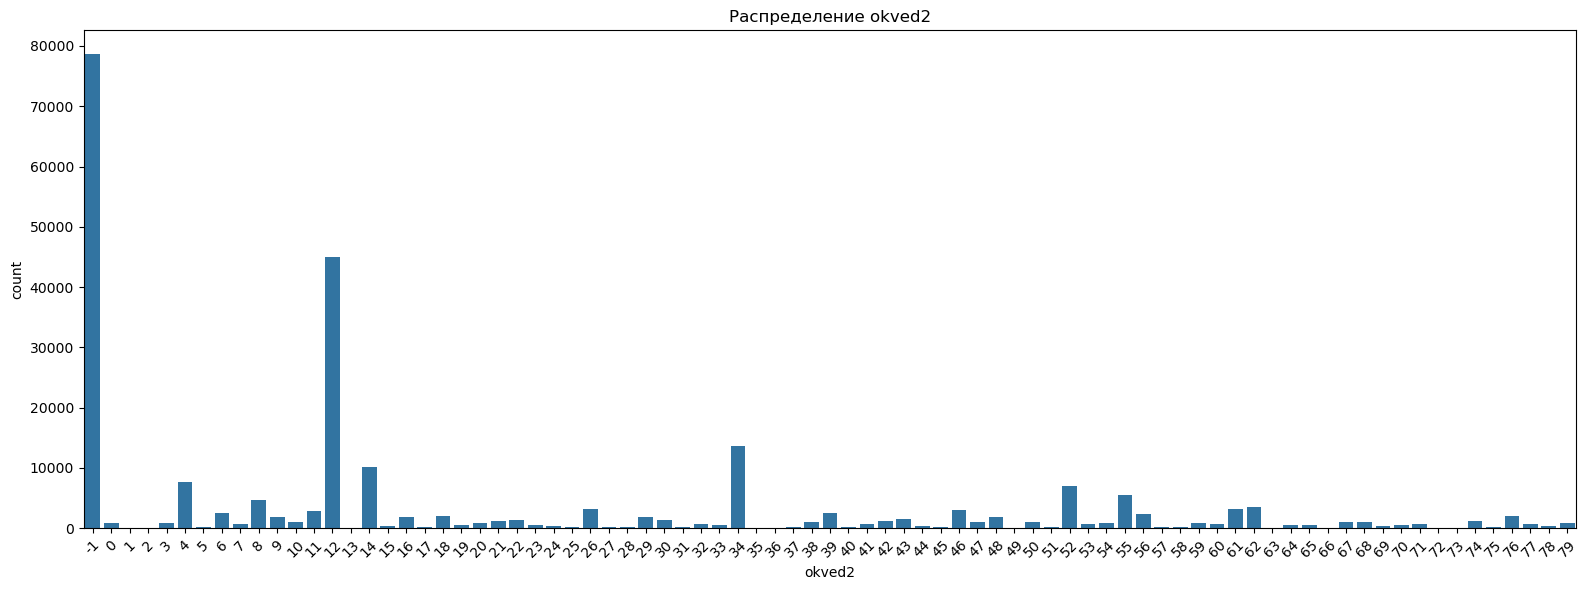

In [9]:
plt.figure(figsize=(16, 6))
sns.countplot(x='okved2', data=inn_info_public)
plt.title('Распределение okved2')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

##### Наблюдается сильный дисбаланс.

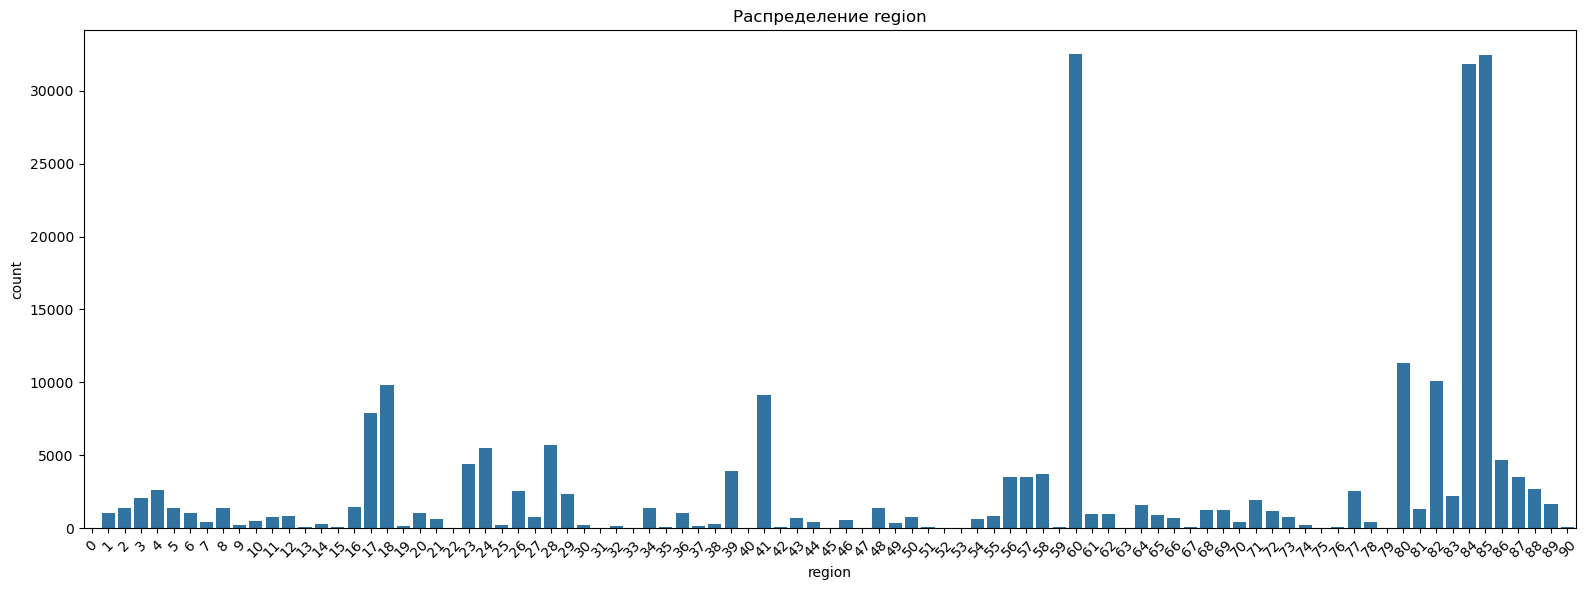

In [10]:
plt.figure(figsize=(16, 6))
sns.countplot(x='region', data=inn_info_public)
plt.title('Распределение region')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

##### И здесь наблюдается сильный дисбаланс.

### Просмотр датафрейма pays

In [11]:
pays

,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6
...,...,...,...,...,...
5430145,260511,77935,5,2,399.6
5430146,260511,77935,12,2,439.6
5430147,260511,77935,14,2,7.6
5430148,260511,77935,15,2,79.6


In [12]:
pays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430150 entries, 0 to 5430149
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   hash_inn_kt  int64  
 1   hash_inn_dt  int64  
 2   week         int64  
 3   count        int64  
 4   sum          float64
dtypes: float64(1), int64(4)
memory usage: 207.1 MB


In [13]:
pays.describe()

,hash_inn_kt,hash_inn_dt,week,count,sum
count,5.430150e+06,5.430150e+06,5.430150e+06,5.430150e+06,5.429025e+06
mean,1.288775e+05,1.305203e+05,1.161926e+01,2.919462e+00,3.939404e+02
std,7.569651e+04,7.564641e+04,6.332949e+00,5.050308e+00,7.259421e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e-01
25%,6.292900e+04,6.476100e+04,6.000000e+00,1.000000e+00,3.280000e+00
50%,1.273810e+05,1.295880e+05,1.200000e+01,2.000000e+00,1.456800e+01
75%,1.943850e+05,1.966060e+05,1.700000e+01,3.000000e+00,6.920000e+01
max,2.605110e+05,2.605150e+05,2.300000e+01,2.530000e+03,3.966400e+06


### Использование функции для подсчета пропущенных значений

In [14]:
missing_pays = percent_missing(pays)
missing_pays

sum    0.020718
dtype: float64

In [15]:
missing_inn = percent_missing(inn_info_public)
missing_inn

Series([], dtype: float64)

### Создание новых фичей

In [16]:
pays_features = pays.groupby('hash_inn_kt').agg(
    total_count=('count', 'sum'),        
    total_sum=('sum', 'sum'),           
    avg_payment=('sum', 'mean'),         
    unique_partners=('hash_inn_dt', 'nunique')  
).reset_index()

In [17]:
pays_features = pays_features.rename(columns={'hash_inn_kt': 'hash_inn'})

In [18]:
pays_features

,hash_inn,total_count,total_sum,avg_payment,unique_partners
0,0,194,253520.588,2982.595153,34
1,1,14,138.000,19.714286,1
2,2,5,36.240,12.080000,3
3,3,1,13.948,13.948000,1
4,4,18,10.160,0.597647,6
...,...,...,...,...,...
152155,260504,96,8691.520,255.632941,14
152156,260507,9,139.016,23.169333,1
152157,260509,584,26427.964,156.378485,26
152158,260510,3,220.760,73.586667,1


### Объединяем таблицы

In [19]:
data = pd.merge(inn_info_public, pays_features, on='hash_inn', how='left')

### Использование функции для подсчета пропущенных значений (для новой таблицы)

In [20]:
missing_data = percent_missing(data)
missing_data

avg_payment        36.619055
total_count        36.618222
total_sum          36.618222
unique_partners    36.618222
dtype: float64

### Заполняем пропущенные значения

In [21]:
data[['avg_payment', 'total_count', 'total_sum', 'unique_partners']] = (
    data[['avg_payment', 'total_count', 'total_sum', 'unique_partners']]
    .fillna(0)
)

### Просмотр датафрейма data

In [22]:
data

,hash_inn,okved2,region,is_public,total_count,total_sum,avg_payment,unique_partners
0,61058,34,86,True,0.0,0.000,0.000000,0.0
1,8311,18,86,True,0.0,0.000,0.000000,0.0
2,130273,-1,86,False,4.0,611.200,305.600000,1.0
3,64081,43,86,True,0.0,0.000,0.000000,0.0
4,218005,12,86,True,20.0,779.500,194.875000,1.0
...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,971.0,198201.748,1524.628831,15.0
240065,13553,12,12,True,22.0,211.320,19.210909,2.0
240066,230402,12,12,True,53.0,4331.076,173.243040,3.0
240067,170104,63,12,True,2.0,149.496,149.496000,1.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   hash_inn         240069 non-null  int64  
 1   okved2           240069 non-null  int64  
 2   region           240069 non-null  int64  
 3   is_public        240069 non-null  bool   
 4   total_count      240069 non-null  float64
 5   total_sum        240069 non-null  float64
 6   avg_payment      240069 non-null  float64
 7   unique_partners  240069 non-null  float64
dtypes: bool(1), float64(4), int64(3)
memory usage: 13.1 MB


In [24]:
data.describe()

,hash_inn,okved2,region,total_count,total_sum,avg_payment,unique_partners
count,240069.000000,240069.000000,240069.000000,240069.000000,2.400690e+05,2.400690e+05,240069.000000
mean,130236.418734,18.771803,58.938343,66.035677,8.908741e+03,2.367433e+02,6.231325
std,75201.512046,22.078592,26.935958,896.086288,1.563183e+05,4.271015e+03,51.123121
min,0.000000,-1.000000,0.000000,0.000000,-1.383200e+01,-4.000000e-01,0.000000
25%,65170.000000,-1.000000,37.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
50%,130169.000000,12.000000,60.000000,3.000000,2.680000e+01,8.009000e+00,1.000000
75%,195380.000000,34.000000,84.000000,18.000000,5.478760e+02,6.310667e+01,3.000000
max,260515.000000,79.000000,90.000000,230374.000000,3.340752e+07,1.458800e+06,10097.000000


### Посмотрим на корреляцию

In [25]:
check_corr = data.select_dtypes(include=[int,float])
check_corr.corr()['okved2'].sort_values()

total_count       -0.005043
unique_partners   -0.003526
total_sum          0.000655
hash_inn           0.001302
avg_payment        0.001429
region             0.013048
okved2             1.000000
Name: okved2, dtype: float64

### Подготовка к обучению

In [26]:
train_df = data[data['okved2'] != -1]
test_df = data[data['okved2'] == -1]

In [27]:
col = ['region', 'total_count', 'total_sum', 'avg_payment', 'unique_partners']

In [28]:
X = train_df[col]
y = train_df['okved2']

### Разделяем наши данные на обучение

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Обучаем модель

In [30]:
model = XGBClassifier(random_state=42)

*можно улучшить модель, через поиск гиперпараметров gridsearchcv.*

 *использовал бы: scoring=f1_weighted, cv=5*

In [31]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Посмотрим на важные фичи

In [32]:
feature_i = pd.DataFrame({
     'feature': col,
     'importance': model.feature_importances_
 }).sort_values('importance')

In [33]:
feature_i

,feature,importance
1,total_count,0.155121
2,total_sum,0.166566
4,unique_partners,0.178435
3,avg_payment,0.183322
0,region,0.316556


### Результаты нашей модели

##### precision, recall, f1, accuracy

In [34]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00       160
           4       0.11      0.01      0.02      1575
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00       451
           7       0.11      0.01      0.01       140
           8       0.13      0.00      0.01       933
           9       0.12      0.01      0.02       387
          10       0.00      0.00      0.00       189
          11       0.00      0.00      0.00       534
          12       0.32      0.89      0.47      8961
          13       0.00      0.00      0.00        16
          14       0.24      0.28      0.25      2048
          15       0.00      0.00      0.00        76
          16       0.00      0.00      0.00       343
          17       0.00    

##### roc_auc

In [35]:
y_pred_proba = model.predict_proba(X_test)

In [36]:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f'roc auc: {roc_auc:.3f}')

roc auc: 0.665


### Предскажем значения для okved2

In [37]:
test_features = test_df[col]  
predictions = model.predict(test_features)

In [38]:
final_predict = pd.DataFrame({
    'hash_inn': test_df['hash_inn'],
    'y': predictions
})

In [39]:
probabilities = model.predict_proba(test_features)
final_predict['probability'] = np.max(probabilities, axis=1)

### Просмотр датафрейма

In [40]:
final_predict.sort_values(by='probability')

,hash_inn,y,probability
208032,169575,34,0.070196
65771,56481,4,0.073343
97085,252241,62,0.073871
124829,193975,14,0.079344
47732,48338,8,0.079786
...,...,...,...
430,144960,12,0.948188
135492,99270,14,0.976982
154768,245123,14,0.986327
43414,79343,14,0.987892


In [41]:
final_predict[['probability']].describe()

,probability
count,78654.000000
mean,0.301807
std,0.121084
min,0.070196
25%,0.209578
50%,0.286870
75%,0.371445
max,0.988497


### Сохранение в csv файл

In [42]:
first_name = "Denis"    
last_name = "Kolenko"   
date_str = datetime.now().strftime("%d%m%Y")
filename = f"{first_name}{last_name}-{date_str}-Sberbank-Industry.csv"

In [43]:
final_predict.to_csv(filename, index=False)